Họ và tên: Trần Hoàng Hà My
MSSV: 22520903

In [256]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages
import random
from scipy.spatial import Voronoi, voronoi_plot_2d

np.random.seed(18)

In [257]:
def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1] 
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

Assignment 1

In [258]:
means = [[2,2], [8,3], [3,6] ]
cov = [[1,0], [0,1]]
N = 200
X0 = np.random.multivariate_normal(means[0],cov,N)
X1 = np.random.multivariate_normal(means[1],cov,N)
X2 = np.random.multivariate_normal(means[2],cov,N)

X = np.concatenate ((X0,X1,X2), axis = 0  )
K = 3
original_label = np.asarray([0] *N + [1]*N + [2]*N ).T


Cài đặt K-means bằng NumPy

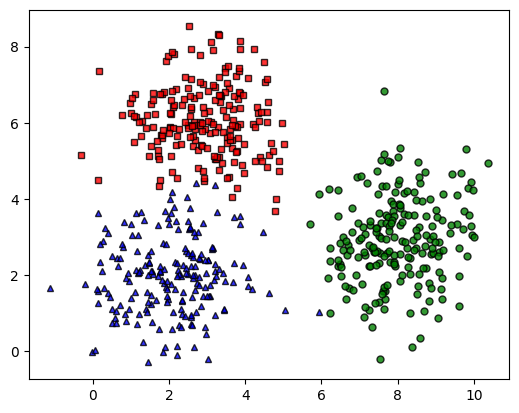

In [259]:
def kmeans_display(X,label):
    X0 = X[label ==0, :]
    X1 = X[label ==1, :]
    X2 = X[label ==2, :]
    
    kwargs = {"markersize":5, "alpha": .8, "markeredgecolor" : 'k'}
    plt.plot(X0[:, 0], X0[:, 1], 'b^', **kwargs)
    plt.plot(X1[:, 0], X1[:, 1], 'go', **kwargs)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', **kwargs)
    
    plt.axis([-3, 12, -2, 10])
    plt.axis('scaled')
    plt.plot()
    plt.show()
kmeans_display(X, original_label)


In [260]:
def kmeans_init_centroids(X, K, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, K, replace=False)
    return X[indices]


def kmeans_assign_labels(X, centroids):
    D = cdist(X, centroids)
    return np.argmin(D, axis = 1)

def kmeans_update_centroids(X, labels, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        Xk = X[labels == k, :]
        centroids[k, :] = np.mean(Xk, axis = 0)
    return centroids
def has_converged(centroids, new_centroids):
    return (set([tuple(a) for a in centroids]) == set ([tuple(a) for a in new_centroids]))

Huấn luyện bằng EM

In [261]:
def kmeans(X, K, random_state=None):
    centroids = [kmeans_init_centroids(X, K, random_state=random_state)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centroids[-1]))
        new_centroids = kmeans_update_centroids(X, labels[-1], K)
        if has_converged(centroids[-1], new_centroids):
            break
        centroids.append(new_centroids)
        it += 1
    return (centroids, labels, it)


Centers found by our algorithm: 
 [[2.00977268 1.97387946]
 [2.94030031 6.04919913]
 [7.98642782 2.93618727]]


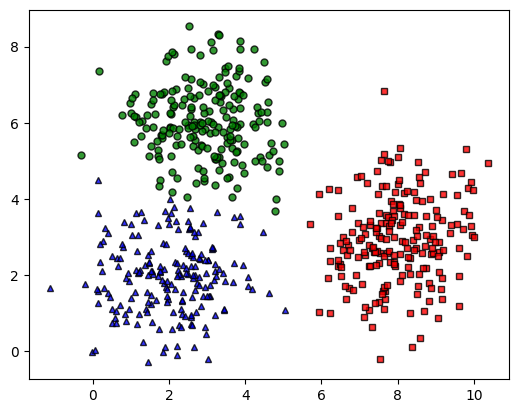

In [262]:
(centroids, labels, it ) = kmeans(X,K)
print('Centers found by our algorithm: \n', centroids[-1])
kmeans_display(X, labels[-1])

Centers found by scikit-learn: 
[[7.98642782 2.93618727]
 [2.94030031 6.04919913]
 [2.00977268 1.97387946]]


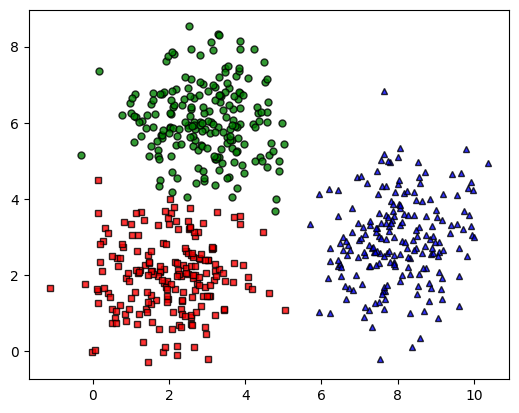

In [263]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by scikit-learn: ')
print(model.cluster_centers_)
pred_label = model.predict(X)
kmeans_display(X, pred_label)

In [264]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def kmeans_display_progress(X, centroids, labels, it, filename='ex.pdf', saving=False):
    label = labels[it]
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]

    plt.figure(figsize=(8, 6))
    
    kwargs = {"markersize": 5, "alpha": 1, "markeredgecolor": 'k'}
    plt.plot(X0[:, 0], X0[:, 1], 'b^', **kwargs)
    plt.plot(X1[:, 0], X1[:, 1], 'go', **kwargs)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', **kwargs)

    points = centroids[it]
    kwargs = {"markersize": 15, "alpha": 1, "markeredgecolor": 'k'}
    plt.plot(points[0, 0], points[0, 1], 'y*', **kwargs)
    plt.plot(points[1, 0], points[1, 1], 'yP', **kwargs)
    plt.plot(points[2, 0], points[2, 1], 'yX', **kwargs)

    colors = ['b', 'g', 'r']
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor, radius=1000)

    for i, region in enumerate(regions):
        polygon = vertices[region]
        plt.fill(*zip(*polygon), alpha=0.3, color=colors[i])

    plt.axis('scaled')
    plt.title('Iteration: %d / %d' % (it + 1, len(labels)))
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

    if saving:
        with PdfPages(filename) as pdf:
            pdf.savefig()
        plt.close()
    else:
        plt.show()


In [265]:
for i in range(6):
    np.random.seed(9*i)
    (centroids, labels, it) = kmeans(X,K)
    print('seed number: ', 9*i, 'number of iterations: ', len(labels))    

seed number:  0 number of iterations:  4
seed number:  9 number of iterations:  7
seed number:  18 number of iterations:  5
seed number:  27 number of iterations:  4
seed number:  36 number of iterations:  8
seed number:  45 number of iterations:  5


In [266]:
for i in range(60):
    np.random.seed(i)
    (centroids, labels, it) = kmeans(X,K)
    print(centroids[-1])

[[2.94030031 6.04919913]
 [2.00977268 1.97387946]
 [7.98642782 2.93618727]]
[[7.98642782 2.93618727]
 [2.94030031 6.04919913]
 [2.00977268 1.97387946]]
[[2.94030031 6.04919913]
 [2.00977268 1.97387946]
 [7.98642782 2.93618727]]
[[7.98642782 2.93618727]
 [2.00977268 1.97387946]
 [2.94030031 6.04919913]]
[[2.00977268 1.97387946]
 [2.94030031 6.04919913]
 [7.98642782 2.93618727]]
[[2.94030031 6.04919913]
 [7.98642782 2.93618727]
 [2.00977268 1.97387946]]
[[2.47140207 4.06103547]
 [7.44442231 2.11413497]
 [8.46112869 3.71845807]]
[[7.98642782 2.93618727]
 [2.00977268 1.97387946]
 [2.94030031 6.04919913]]
[[2.94030031 6.04919913]
 [7.98642782 2.93618727]
 [2.00977268 1.97387946]]
[[7.98642782 2.93618727]
 [2.00977268 1.97387946]
 [2.94030031 6.04919913]]
[[7.98642782 2.93618727]
 [2.00977268 1.97387946]
 [2.94030031 6.04919913]]
[[7.46132042 2.08150961]
 [8.42549095 3.71866253]
 [2.47140207 4.06103547]]
[[7.98642782 2.93618727]
 [2.00977268 1.97387946]
 [2.94030031 6.04919913]]
[[2.94030031

Seed=10, Centroids:
 [[2.17801024 3.4185961 ]
 [0.88123333 1.92613582]
 [2.61775209 5.40136788]]


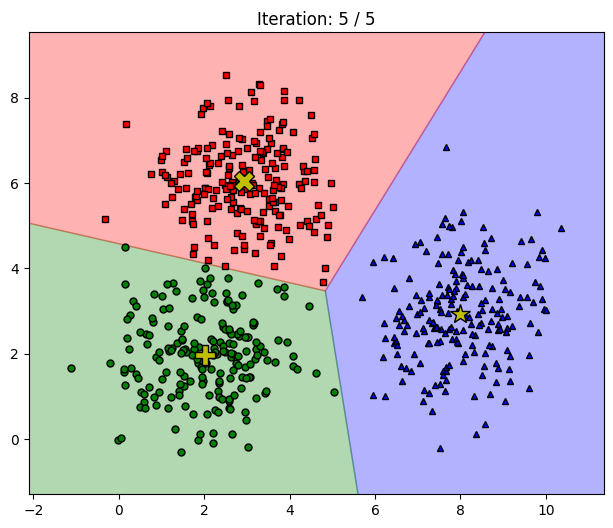

Seed=31, Centroids:
 [[2.0420179  1.78073866]
 [1.46990827 2.34363963]
 [6.4916317  2.83367643]]


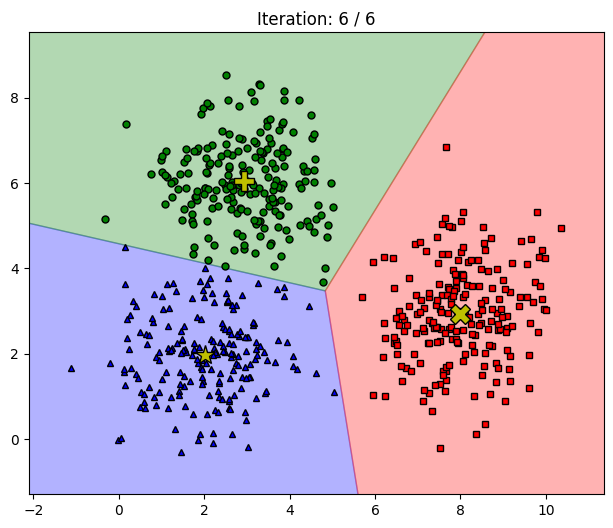

Seed=27, Centroids:
 [[2.41180673 7.20581825]
 [8.71078522 4.70292477]
 [0.64956782 2.23009402]]


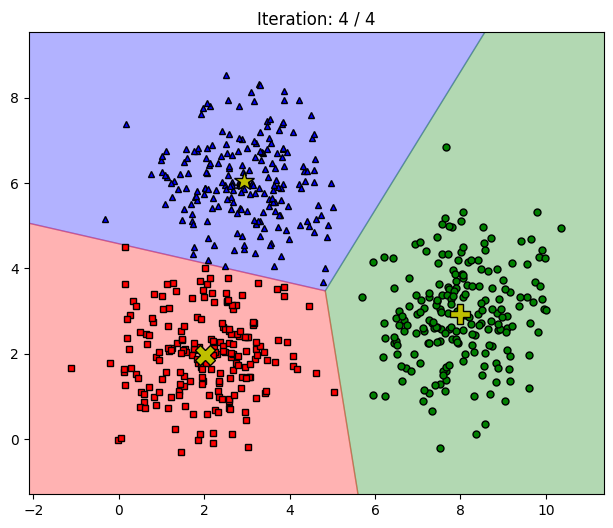

In [267]:
for i in [10, 31, 27]:
    centroids, labels, it = kmeans(X, K, random_state=i)
    print(f"Seed={i}, Centroids:\n", centroids[0])
    kmeans_display_progress(X, centroids, labels, it, saving=False)


Assignment 2 

10


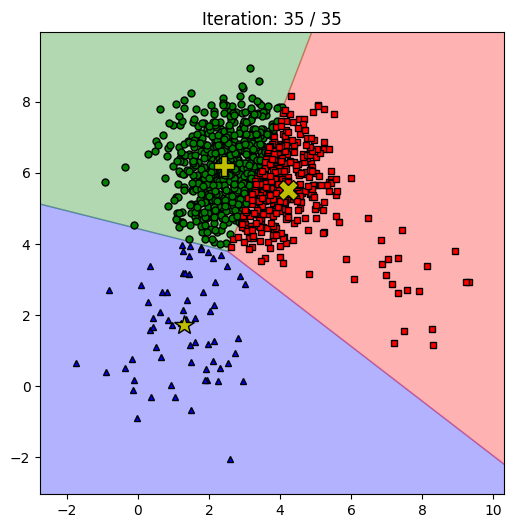

In [268]:
means = [[1,1], [8,3], [3,6]]
cov = [[1,0], [0,1]]
N = [50,20,1000]
X0 = np.random.multivariate_normal(means[0], cov, N[0])
X1 = np.random.multivariate_normal(means[1], cov, N[1])
X2 = np.random.multivariate_normal(means[2], cov, N[2])


X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

for i in [10] :
    np.random.seed(i)
    (centroids, labels, it ) = kmeans(X,K)
    it = len (labels) -1
    print(i)
    filename = 'skew_' + str(i) + '.pdf'
    kmeans_display_progress(X, centroids, labels, it, saving = False)


Các cluster không có dạng tròn 

 Assignment 3

10


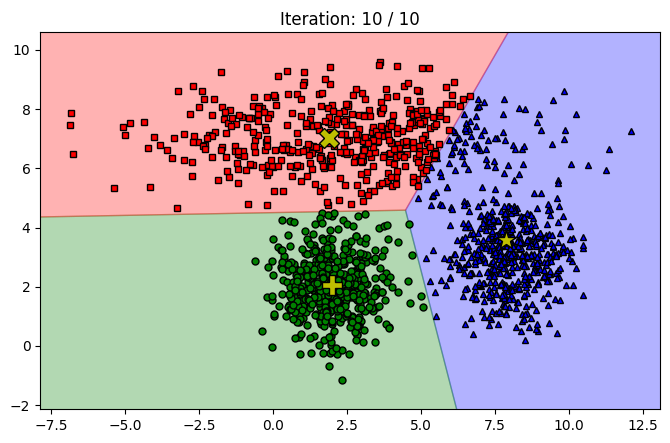

In [269]:
means = [[2,2], [8,3], [3,7]]
cov = [[1,0], [0,1]]
cov2 = [[10,0], [0,1]]

N = [500,500,500]
X0 = np.random.multivariate_normal(means[0], cov, N[0])
X1 = np.random.multivariate_normal(means[1], cov, N[1])
X2 = np.random.multivariate_normal(means[2], cov2, N[2])


X = np.concatenate((X0, X1, X2), axis = 0)
K = 3
for i in [10] :
    np.random.seed(i)
    (centroids, labels, it ) = kmeans(X,K)
    it = len (labels) -1
    print(i)
    filename = 'notround_' + str(i) + '.pdf'
    kmeans_display_progress(X, centroids, labels, it=len(labels)-1)


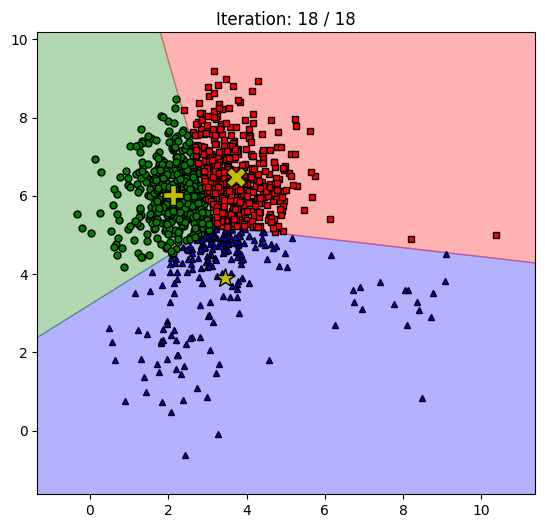

In [270]:
np.random.seed(27)
means = [[2,2], [8,3], [3,6]]  
cov = [[1,0], [0,1]]
N = [50,20,1000]

X0 = np.random.multivariate_normal(means[0], cov, N[0])
X1 = np.random.multivariate_normal(means[1], cov, N[1])
X2 = np.random.multivariate_normal(means[2], cov, N[2])

X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

(centroids, labels, it) = kmeans(X, K)
filename = 'dif_res27.pdf'
kmeans_display_progress(X, centroids, labels, it=len(labels)-1)
